# This cat does not exist
__Суммарное количество баллов: 10__

Цель этого задания - создать котов, которых не существует. В ходе данного задания вы обучите DCGAN и VAE, которые являются одними из первых генеративных моделей. Для этого задания вам наверняка потребуется GPU с CUDA, поэтому рекомендуется использовать Google Colab.

In [ ]:
import torch
from torch import nn
from torch.optim import Adam,NAdam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import numpy as np

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip - '/content/drive/MyDrive/cat_136/cat_136.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: cat_136/flickr_cat_000168.jpg  
  inflating: cat_136/flickr_cat_000169.jpg  
  inflating: cat_136/flickr_cat_000170.jpg  
  inflating: cat_136/flickr_cat_000171.jpg  
  inflating: cat_136/flickr_cat_000172.jpg  
  inflating: cat_136/flickr_cat_000173.jpg  
  inflating: cat_136/flickr_cat_000178.jpg  
  inflating: cat_136/flickr_cat_000179.jpg  
  inflating: cat_136/flickr_cat_000181.jpg  
  inflating: cat_136/flickr_cat_000185.jpg  
  inflating: cat_136/flickr_cat_000186.jpg  
  inflating: cat_136/flickr_cat_000187.jpg  
  inflating: cat_136/flickr_cat_000188.jpg  
  inflating: cat_136/flickr_cat_000189.jpg  
  inflating: cat_136/flickr_cat_000190.jpg  
  inflating: cat_136/flickr_cat_000192.jpg  
  inflating: cat_136/flickr_cat_000193.jpg  
  inflating: cat_136/flickr_cat_000194.jpg  
  inflating: cat_136/flickr_cat_000195.jpg  
  inflating: cat_136/flickr_cat_000196.jpg  
  inflating: cat_136/flickr_cat_

In [ ]:
def random_noise(batch_size, channels, side_size):
    return torch.randn(batch_size, channels, side_size, side_size).cuda()

In [ ]:
def visualise(imgs, rows=2):
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
class CatDataset(Dataset):
    def __init__(self, path_to_dataset="/content/cat_136", size=64):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
        self.size = size

    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path) # 136 x 136
        crop_rate = 8
        x_crop = random.randint(0, crop_rate)
        y_crop = random.randint(0, crop_rate)
        img = img[x_crop:136 - crop_rate + x_crop,
                  y_crop:136 - crop_rate + y_crop]
        img = cv2.resize(img, (self.size, self.size),
                         interpolation=cv2.INTER_CUBIC)
        return 2 * torch.tensor(img).float().transpose(0, 2) / 255. - 1

    def __len__(self):
        return len(self.photo_names)

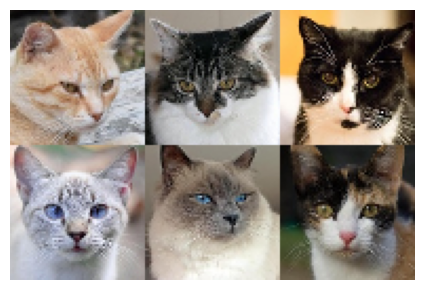

In [ ]:
dataset = CatDataset()
visualise(torch.cat([dataset[i].unsqueeze(0) for i in [3, 15, 182, 592, 394, 2941]], dim=0))

### Задание 1 (2 балла)
Для начала реализуем кодировщик для нашего VAE. Предлагается использовать следующую архитектуру:
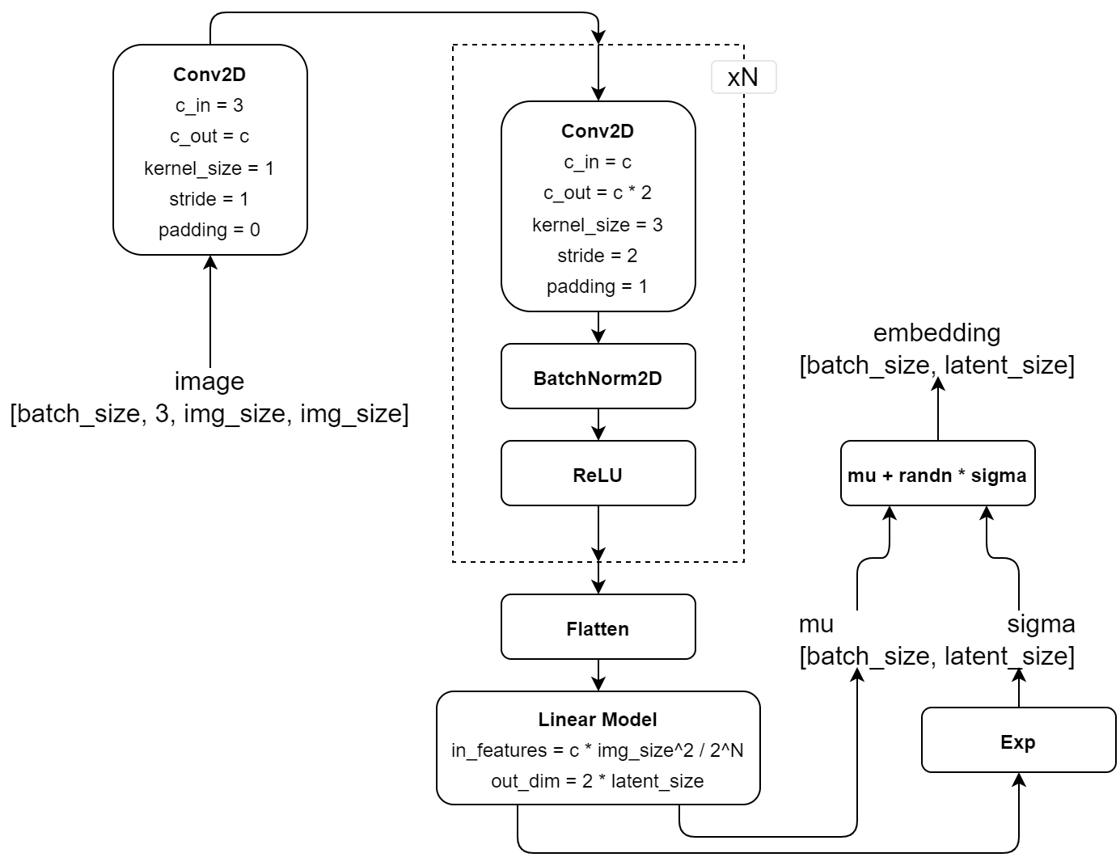
![](imgs/VAE_enc.png)

Для ее реализации вам потребуются модули `nn.Conv2d`, `nn.ReLU`, `nn.Flatten` и `nn.Linear`.

#### Методы
* `__init__` - принимает на вход `img_size`, `latent_size`, `start_channels` и `downsamplings`. Первый аргумент - высота и ширина картинки в пикселях. Второй аргумент - размерность латентного пространства. `start_channels` отвечает за то, сколько каналов должно быть в картинке перед тем, как к ней будут применены downsampling блоки. `downsamplings` - это количество downsampling блоков, которые должны быть применены к картинке. В каждом таком блоке количество каналов увеличивается в два раза.


* `forward` - принимает на вход батч `x`, возвращает эмбеддинг в латентном пространстве `z` и параметры распределения `(mu, sigma)`.


#### Важно
`Linear Model` в схеме - это полносвязная сеть из нескольких слоев. Предлагается такая архитектура:

`[Linear(c * img_size // 2^N -> 256), ReLU, Linear(256 -> 2 * latent_size)]`

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


# Task 1

class Encoder(nn.Module):
    def __init__(self, img_size=128, latent_size=512, start_channels=16,
                 downsamplings=5):
        super().__init__()
        self.img_size = img_size
        self.latent_size = latent_size
        self.start_channels = start_channels
        self.downsamplings = downsamplings


        self.inptl = nn.Conv2d(in_channels=3, out_channels=self.start_channels,
                               kernel_size=1,stride=1,padding=0)

        self.dwn = self.downsamplings_layers()
        self.flt = nn.Flatten()
        self.linear1 = nn.Linear( self.start_channels*self.img_size**2 // (2**self.downsamplings),
                                 256)

        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256, 2*self.latent_size)




    def downsamplings_layers(self):
        res = []
        self.c = self.start_channels
        for _ in range(self.downsamplings):
            res += [nn.Conv2d(in_channels=self.c,out_channels=self.c*2,
                              kernel_size=3,stride=2,padding=1),
                nn.BatchNorm2d(self.c*2),
                nn.ReLU()]
            self.c *= 2

        res = nn.ModuleList(res)
        return nn.Sequential(*res)

    def forward(self, x):

        x = self.inptl(x)
        x = self.dwn(x)
        x = self.flt(x)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        mu = x[:, :self.latent_size]
        sigma = torch.exp(x[:, self.latent_size:])
        rand = torch.randn_like(sigma)

        z = mu + (rand * sigma)

        return z, (mu, sigma)

### Задание 2 (3 балла)
Теперь реализуем декодер для VAE. Предлагается использовать следующую архитектуру:

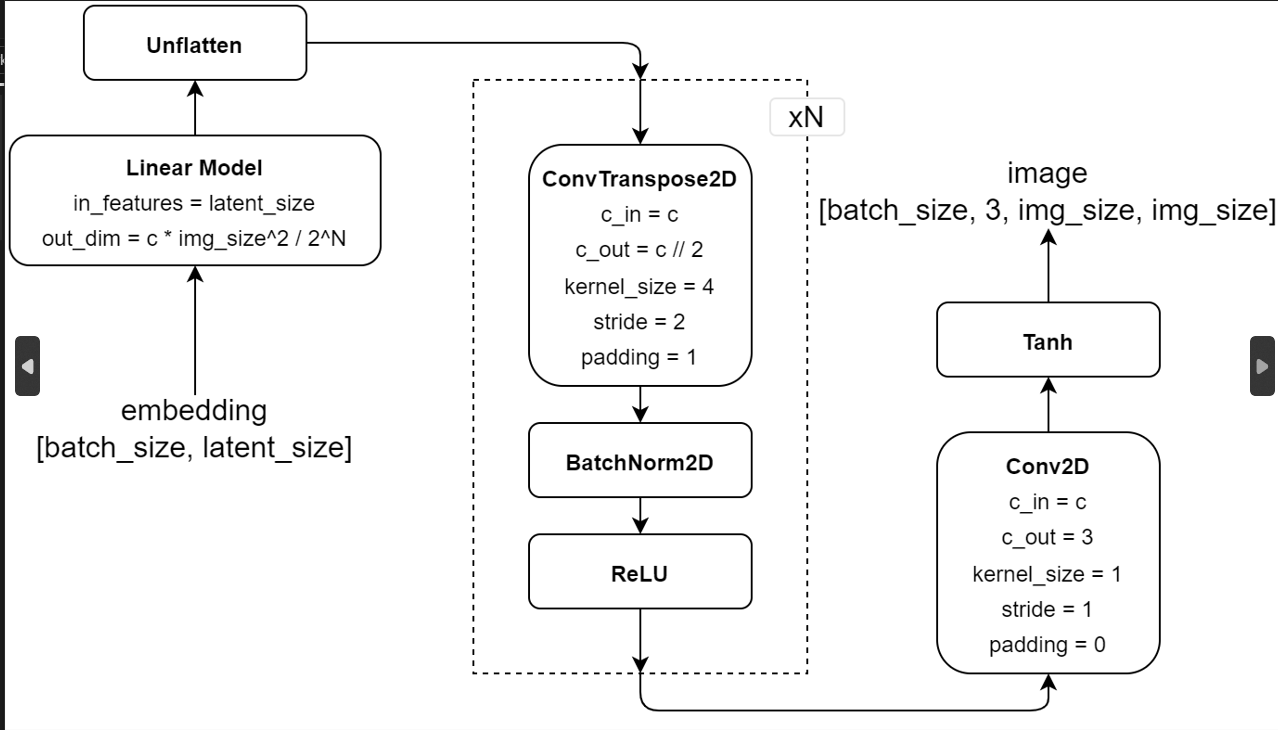![](imgs/VAE_dec.png)

Для ее реализации вам потребуются модули `nn.Linear`, `nn.Unflatten`, `nn.ConvTranspose2d`, `nn.ReLU` и `nn.Tanh`.

#### Методы
* `__init__` - принимает на вход `img_size`, `latent_size`, `end_channels` и `upsamplings`.  Первый аргумент - высота и ширина картинки в пикселях. Второй аргумент - размерность латентного пространства. `end_channels` отвечает за то, сколько каналов должно быть после всех upsampling блоков. `upsamplings` - это количество upsampling блоков, которые должны быть применены к картинке. В каждом таком блоке количество каналов уменьшается в два раза.


* `forward` - принимает на вход `z` - тензор с латентным представлением изображений. Возвращает батч восстановленных изображений.

#### Важно
`Linear Model` в схеме - это полносвязная сеть из нескольких слоев. Предлагается такая архитектура:

`[Linear(latent_size -> 256), ReLU, Linear(256 -> c * 2^N)]`

In [ ]:
class Decoder(nn.Module):
    def __init__(self, img_size=128,latent_size=1024,end_channels=16,
                 upsamplings=5):
        super().__init__()
        self.img_size = img_size
        self.latent_size = latent_size
        self.end_channels = end_channels
        self.upsamplings = upsamplings
        self.pic_size = self.img_size//2**self.upsamplings



        self.linear1 = nn.Linear(self.latent_size, 160)
        self.relu  =  nn.ReLU()
        self.linear2 = nn.Linear(160,self.end_channels*self.img_size**2//2**self.upsamplings)

        self.unflt = nn.Unflatten(dim=1,unflattened_size=(self.end_channels*2**self.upsamplings,
                                                          self.pic_size,
                                                          self.pic_size) )
        self.upsmpl = self.upsamplings_layers()
        self.convout = nn.Conv2d(in_channels=self.end_channels,
                                 out_channels=3,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.pred = nn.Tanh()


    def upsamplings_layers(self):
        res = []
        self.c =  self.end_channels * 2 ** self.upsamplings
        for _ in range(self.upsamplings):
            res += [nn.ConvTranspose2d(in_channels=self.c,
                                       out_channels=self.c // 2,
                                       kernel_size=4,
                                       stride=2,padding=1),
                nn.BatchNorm2d(self.c // 2),
                nn.ReLU()]
            self.c //= 2
        res = nn.ModuleList(res)
        return nn.Sequential(*res)


    def forward(self, z):
        z = self.linear1(z)
        z = self.relu(z)
        z = self.linear2(z)

        z = self.unflt(z)
        z = self.upsmpl(z)
        z = self.convout(z)
        z = self.pred(z)

        return z

### Задание 3 (5 баллов)
Наконец, объединим Encoder и Decoder в Variational Autoencoder.

Полностью архитектура выглядит так:
![](imgs/VAE.png)

Из нее можно выделить две части: Encoder (по изображению возвращает mu и sigma) и Decoder (по случайному шуму восстанавливает изображение). На высоком уровне VAE можно представить так:

![](imgs/VAE_highlevel.png)

В данном задании вам необходимо реализовать полную архитектуру VAE.

#### Методы
* `__init__` - принимает на вход `img_size`, `downsamplings`, `latent_size`, `linear_hidden_size`, `down_channels` и `up_channels`. `img_size` - размер стороны входного изображения. `downsamplings` - количество downsampling (и upsampling) блоков. `latent_size` - размер латентного пространства, в котором в который будет закодирована картинка. `linear_hidden_size` количество нейронов на скрытом слое полносвязной сети в конце encoder'а. Для полносвязной сети decoder'а это число стоит умножить на 2. `down_channels` - количество каналов, в которое будет преобразовано трехцветное изображение перед применением `downsampling` блоков. `up_channels` - количество каналов, которое должно получиться после применения всех upsampling блоков.

* `forward` - принимает на вход `x`. Считает распределение $N(\mu, \sigma^2)$ и вектор $z \sim N(\mu, \sigma^2)$. Возвращает $x'$ - восстановленную из вектора $z$ картинку и $D_{KL}(N(\mu, \sigma^2), N(0, 1)) = 0.5 \cdot (\sigma^2 + \mu^2 - \log \sigma^2 - 1)$.

* `encode` - принимает на вход `x`. Возвращает вектор из распределения $N(\mu, \sigma^2)$.

* `decode` - принимает на вход `z`. Возвращает восстановленную по вектору картинку.

* `save` - сохраняет чекпоинт обученной модели.

* `load` - загружает сохраненный чекпоинт обученной модели.


#### Если хочется улучшить качество
https://arxiv.org/pdf/1906.00446.pdf

In [ ]:

class VAE(nn.Module):
    def __init__(self, img_size=128,downsamplings=5,latent_size=512,
                 down_channels=8, up_channels=14):
        super().__init__()
        self.encoder = Encoder(img_size=img_size,downsamplings=downsamplings,
                               latent_size=latent_size,
                               start_channels=down_channels)
        self.decoder = Decoder(img_size=img_size,latent_size=latent_size,
                               end_channels=up_channels,
                               upsamplings=downsamplings)

    def forward(self, x):
        z, (mu,sigma) = self.encoder.forward(x)
        x_pred = self.decoder.forward(z)
        kld = 0.5*(sigma**2 + mu**2 - torch.log(sigma**2) - 1)

        return x_pred, kld

    def encode(self, x):
        z = self.encoder.forward(x)[0]
        return z

    def decode(self, z):
        x_pred =self.decoder.forward(z)
        return x_pred

    def save(self):


        torch.save(self.state_dict(),'/content/drive/MyDrive/vae1w/mmw.pth')

    def load(self):
        self.load_state_dict(self,torch.load('/content/drive/MyDrive/vae1w/mmw.pth',map_location=torch.device('cpu') ))
        return self.eval()


In [ ]:
def train_vae():
    vae = VAE()
    vae.cuda()


    epochs = 201
    batch_size = 8
    vae_optim = NAdam(vae.parameters(), lr=1e-4)

    dataset = CatDataset(size=128)

    test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
    test_imgs_2 = torch.cat([dataset[i].unsqueeze(0) for i in (734, 123, 512, 3634)])

    maxloss = 1e4

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0
        if ep % 10 == 0:
            with torch.no_grad():
                z_1 = vae.encode(test_imgs_1.cuda())
                z_2 = vae.encode(test_imgs_2.cuda())
                x_int = []
                for i in range(9):
                    z = (i * z_1 + (8 - i) * z_2) / 8
                    x_int.append(vae.decode(z))
                x_int = torch.cat(x_int)
                visualise(x_int, rows=len(test_imgs_1))
                z_rand = torch.randn_like(z_1)
                x_int = vae.decode(z_rand)
                visualise(x_int, rows=len(test_imgs_1)//2)

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            x = batch.cuda()
            x_rec, kld = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x)**2).sum() / batch_size
            loss = rec_loss + 0.1 * kld_loss # https://openreview.net/forum?id=Sy2fzU9gl
            vae_optim.zero_grad()
            #loss.backward(retain_graph=True)
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()


        if rec_loss_avg / total_batches < maxloss:
              maxloss = rec_loss_avg / total_batches
              print(f'model has been upload at loss = {maxloss}')
              vae.save()

        print(f"Epoch {ep+1} | Reconstruction loss: {rec_loss_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")


train_vae()

In [ ]:
model = VAE().load()